In [ ]:
import numpy as np

a=np.array()

读取划分mask的交集部分

In [5]:
l1=[0,1 ,2 ,0]
l2=[0]*len(l1)
l2=[1 for i in l1 if i == 2]

print(l1)

[0, 1, 2, 0]


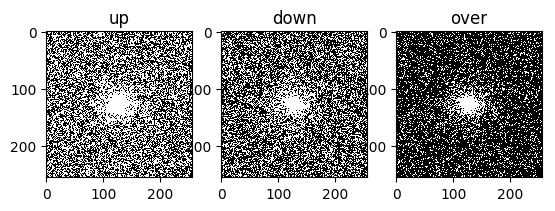

In [14]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

mask_up_path='/home/liuchun/Desktop/ovlm_parallel_02/mask/selecting_mask/mask_2.00x_acs16.mat'
mask_down_path='/home/liuchun/Desktop/ovlm_parallel_02/mask/selecting_mask/mask_2.50x_acs16.mat'

mask_up = np.array(sio.loadmat(mask_up_path)['mask'])
mask_down = np.array(sio.loadmat(mask_down_path)['mask'])

mask_add=mask_up+mask_down
mask_over = np.where(mask_add==2,1,0)

plt.subplot(131)
plt.title('up')
plt.imshow(mask_up,cmap='gray')

plt.subplot(132)
plt.title('down')
plt.imshow(mask_down,cmap='gray')

plt.subplot(133)
plt.title('over')
plt.imshow(mask_over,cmap='gray')

# plt.show

将得到的结果保存为.mat文件 交集的结果存储在mask_over.mat文件中

type(data): <class 'numpy.ndarray'>
data.shape: (256, 256)
[ True]


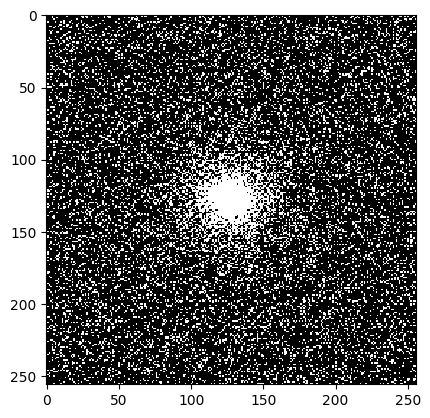

In [21]:
import scipy.io as scio  # 需要用到scipy库
import scipy
import numpy as np
my_data=mask_over
# 保存到当前路径下
save_path='/home/liuchun/Desktop/ovlm_parallel_02/mask/selecting_mask/mask_over.mat'
scipy.io.savemat(save_path, {'data':my_data})  # file_name.mat为保存的文件名。该保存的mat文件可直接在matlab打开
# 读取刚保存的.mat数据
dict_ = scio.loadmat(save_path)  # 输出的为dict字典类型
data=dict_['data']  # 从字典中将数据取出
print('type(data):',type(dict_['data'])) # numpy.ndarray
print('data.shape:',data.shape)
plt.imshow(data,cmap='gray')
print(np.unique(mask_over==data))

按照指定条件设置数组的值


In [11]:
a = np.arange(10)
print(a)
# //array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(np.where(a > 5, 1, -1))
# //array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1]) 


[0 1 2 3 4 5 6 7 8 9]
[-1 -1 -1 -1 -1 -1  1  1  1  1]


将numpy数组存成.mat文件

In [17]:
import scipy.io as scio  # 需要用到scipy库
import scipy
import numpy as np
my_data=np.arange(12) # 0-11
# 保存到当前路径下
test_save_path='/home/liuchun/Desktop/ovlm_parallel_02/mask/selecting_mask/file_name.mat'
scipy.io.savemat(test_save_path, {'data':my_data})  # file_name.mat为保存的文件名。该保存的mat文件可直接在matlab打开
# 读取刚保存的.mat数据
dict_ = scio.loadmat(test_save_path)  # 输出的为dict字典类型
data=dict_['data']  # 从字典中将数据取出
print(type(dict_['data'])) # numpy.ndarray


<class 'numpy.ndarray'>


根据另一个数组的数值 创建对应数组


In [24]:
a=np.array([[1, 2, 3],[1, 2, 3]])
b=np.array([[1,1,1],[1,1,1]])
b[a>2]=100
print(b)

[[  1   1 100]
 [  1   1 100]]


测试两个list相加的结果

In [28]:
a=np.array([[1,2,0],[3,4,0],[5,6,7]])
b=np.array([[5,5,5],[1,1,1],[2,2,2]])
c1=((a - b) ** 2).mean()
c2=np.mean(np.abs(a - b) ** 2)

print(c1,c2)

12.666666666666666 12.666666666666666


In [29]:
import cv2


img_out.shape: (330, 440)


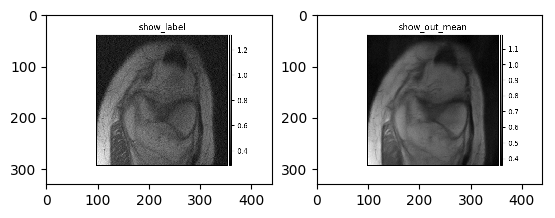

res1: 32.90787141176758
res2: 32.90787141176758


In [10]:
from typing import Sequence, Tuple
import numpy as np
import math
import torch
from functools import reduce
import operator



def compute_mse_q(x, y, axis=None):
    """
    REQUIREMENT: `x` and `y` can be any shape, but their shape have to be same
    """
    assert x.dtype == y.dtype and x.shape == y.shape, \
        'x and y is not compatible to compute MSE metric'

    if axis:
        mse = ((x - y) ** 2).mean(axis=axis)
    else:
        mse = ((x - y) ** 2).mean()

    return mse


def axes_to_last_order(ndim, axes_idx: Sequence[int]):
    """
    根据数组尺寸长度和最后两个轴的索引计算出 permute的索引顺序
    Generate axes order of move the axes specifed by `axes_idx` to last in a n-dimension axes,
    return indices can used to permute(array, indices) and inverse_indices can used
    to restore the data by permute(array, inverse_indices)
    eg.
        (Nb, Nx, Ny, Ntime) --move(2,3)--> (Nb, Ntime, Nx, Ny) may be wrong
        (..., Nx, Ny, Ntime, Nslice) --move(-4,-3)--> (..., Ntime, Nslice, Nx, Ny)
        shape (1,2,3,4,5) --move(3,2)--> shape (1,2,5,4,3)
    """
    # convert reversed index to ordinal index eg: -1,-2  ---> 3,2(when the len of shape is 4)
    axes_need_move = [(axis if axis >= 0 else ndim + axis) for axis in axes_idx]

    # generate forward-indices
    forward_indices = tuple([axis for axis in range(ndim) if axis not in axes_need_move] + axes_need_move)

    # generate inverse-indices
    inverse_indices = np.argsort(forward_indices).tolist() #argsort 将数组中的元素按照从小到大进行排序 输出对应排序后的索引

    return forward_indices, inverse_indices

def compute_psnr_q(x, y, peak='normalized', image_axes=(-2, -1), reduction='mean', eps=1e-16):
    '''
    Image must be of either Integer [0, 255] or Float value [0,1]
    :param peak: 'max' or 'normalize', max_intensity will be the maximum value of target_im if peek == 'max.
          when peek is 'normalized', max_intensity will be the maximum value depend on data representation (in this
          case, we assume your input should be normalized to [0,1])
    :param image_axes: specify the image's axes (H, W)
    :param eps: to avoid math error in log(x) when x=0
    REQUIREMENT: `x` and `y` is [..., H, W, ...], their shape have to be same
    '''
    assert len(x.shape) >= 2
    assert y.dtype == x.dtype and y.shape == x.shape, \
        f"shape of x {x.shape} and shape of y {y.shape} is not compatible to compute PSNR metric"
    assert peak in {'max', 'normalized'}, \
        'peak mode is not supported'

    axes_permutation_order, _ = axes_to_last_order(len(x.shape), image_axes)
    H, W = x.shape[image_axes[0]], x.shape[image_axes[1]]
    # N = math.prod(x.shape) // math.prod((H, W))
    aa=reduce(operator.mul, x.shape, 1)
    bb=reduce(operator.mul, [H, W], 1)
    N = aa // bb


    if isinstance(y, np.ndarray):
        max_intensity = 255 if y.dtype == np.uint8 else 1.0
        max_intensity = np.max(y).item() if peak == 'max' else max_intensity
        fn_log10 = np.log10

        x = x.transpose(axes_permutation_order).reshape(N, H, W)
        y = y.transpose(axes_permutation_order).reshape(N, H, W)
        psnr = np.zeros(N)
    elif isinstance(y, torch.Tensor):
        max_intensity = 255 if y.dtype == torch.uint8 else 1.0
        max_intensity = torch.max(y).item() if peak == 'max' else max_intensity
        fn_log10 = torch.log10

        x = x.permute(axes_permutation_order).reshape(N, H, W)
        y = y.permute(axes_permutation_order).reshape(N, H, W)
        psnr = torch.zeros(N)
    else:
        raise RuntimeError('Unsupported object type')

    for i in range(N):
        psnr[i] = 20 * math.log10(max_intensity) - 10 * fn_log10(compute_mse_q(x[i, ...], y[i, ...]) + eps)

    if reduction == 'mean':
        psnr = psnr.mean()  # [1,]
    elif reduction == 'sum':
        psnr = psnr.sum()  # [1,]
    elif reduction == 'none':
        pass  # [N, ]
    else:
        raise RuntimeError('Unsupported reduction type')

    return psnr

def minmax_normalize(x, eps=1e-8):
    min = x.min()
    max = x.max()
    return (x - min) / (max - min + eps)


def compute_mse(x, y):
    """
    REQUIREMENT: `x` and `y` can be any shape, but their shape have to be same
    """
    assert x.dtype == y.dtype and x.shape == y.shape, \
        'x and y is not compatible to compute MSE metric'

    if isinstance(x, np.ndarray):
        mse = np.mean(np.abs(x - y) ** 2)

    elif isinstance(x, torch.Tensor):
        mse = torch.mean(torch.abs(x - y) ** 2)

    else:
        raise RuntimeError(
            'Unsupported object type'
        )
    return mse


def compute_psnr(reconstructed_im, target_im, peak='normalized', is_minmax=False):
    '''
    Image must be of either Integer [0, 255] or Float value [0,1]
    :param peak: 'max' or 'normalize', max_intensity will be the maximum value of target_im if peek == 'max.
          when peek is 'normalized', max_intensity will be the maximum value depend on data representation (in this
          case, we assume your input should be normalized to [0,1])
    REQUIREMENT: `x` and `y` can be any shape, but their shape have to be same
    '''
    assert target_im.dtype == reconstructed_im.dtype and target_im.shape == reconstructed_im.shape, \
        'target_im and reconstructed_im is not compatible to compute PSNR metric'
    assert peak in {'max', 'normalized'}, \
        'peak mode is not supported'

    # eps = 1e-8  # to avoid math error in log(x) when x=0
    eps = 1e-16  # to avoid math error in log(x) when x=0

    if is_minmax:
        reconstructed_im = minmax_normalize(reconstructed_im, eps)
        target_im = minmax_normalize(target_im, eps)

    if isinstance(target_im, np.ndarray):
        max_intensity = 255 if target_im.dtype == np.uint8 else 1.0
        max_intensity = np.max(target_im).item() if peak == 'max' else max_intensity
        psnr = 20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)

    elif isinstance(target_im, torch.Tensor):
        max_intensity = 255 if target_im.dtype == torch.uint8 else 1.0
        max_intensity = torch.max(target_im).item() if peak == 'max' else max_intensity
        psnr = 20 * math.log10(max_intensity) - 10 * torch.log10(compute_mse(reconstructed_im, target_im) + eps)

    else:
        raise RuntimeError(
            'Unsupported object type'
        )
    return psnr



import cv2
import matplotlib.pyplot as plt
import pylab

if __name__=="__main__":
    # forward_indices, inverse_indices=axes_to_last_order((1,2,3,4,5),(3,2))
    # forward_indices, inverse_indices=axes_to_last_order(5,(3,2)) 
    # forward_indices, inverse_indices=axes_to_last_order(5,(4,2)) 
    # print('forward_indices:',forward_indices)
    # print('inverse_indices:',inverse_indices)

    # image_size = [256, 256] #将图像转化为512*512大小的尺寸 
    # imag1 = cv2.resize(imag1, image_size, interpolation=cv2.INTER_CUBIC)
    # #检验psnr计算函数
    img_label = cv2.imread("/home/liuchun/Desktop/parallel_02/train_imgs/wantfig1/1label.png")
    img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)
    # print('img_label.dtype:',img_label.dtype)
    # print("img_label.shape: {}".format(img_label.shape))
    plt.subplot(121)
    plt.imshow(img_label,cmap='gray')

    img_out = cv2.imread("/home/liuchun/Desktop/parallel_02/train_imgs/wantfig1/1.png")
    img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2GRAY)
    print("img_out.shape: {}".format(img_out.shape))
    # cv2.imshow("img_out", img_out)    # 显示图像
    # cv2.waitKey()               # 默认为0，无限等待
    # cv2.destroyAllWindows()      # 释放所有窗口
    plt.subplot(122)
    plt.imshow(img_out,cmap='gray')
   
    plt.show()
    # pylab.show()

    res1 = compute_psnr_q(img_label, img_out)
    print("res1:", res1)
    res2 = compute_psnr(img_label, img_out)
    print("res2:", res2)